In [1]:
from flow2ml import Flow

For demonstration, we use 20 images for each class from the horses vs humans dataset found [here.](https://www.kaggle.com/sanikamal/horses-or-humans-dataset)

## Image operations

After initialising the `Flow` object, a countplot for various categories is added to the saved in the GeneratedReports folder as categories_countplot.docx.

Counts per each category
Category horses: 20
Category humans: 20


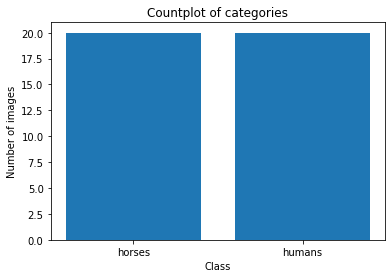

In [2]:
# Initialise the Flow object
flow = Flow( 'dataset_dir' , 'data_dir' )

A list of filters to apply to the images is provided as input to `applyFilters.` A random image is picked and all the filters applied on it are visualised in a single graph. The image is also saved to the GeneratedReports folder as visualise_filters.png.

Percent: [##########] 100% Filtered all images in horses ...
Percent: [##########] 100% Filtered all images in humans ...



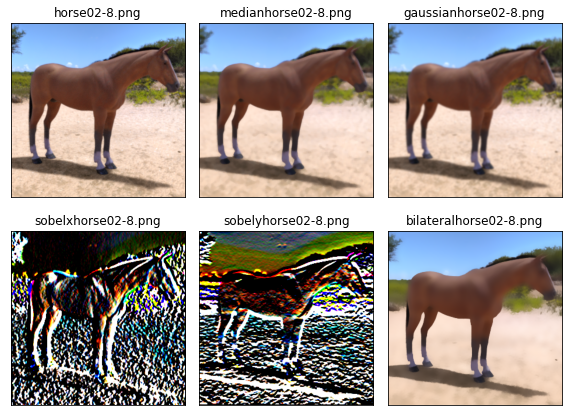

In [3]:
# Define The Filters to be used
filters = ["median", "gaussian", "sobelx", "sobely", "bilateral"]

# Apply The Filters
flow.applyFilters( filters )

A dictionary of augmentations and respective parameters is provided as input to `applyAugmentation.` A random image is picked and all the augmentations applied on it are visualised in a single graph. The image is also saved to the GeneratedReports folder as visualise_augmentation.png.

Percent: [##########] 100% Augmented all images in horses ...
Percent: [##########] 100% Augmented all images in humans ...



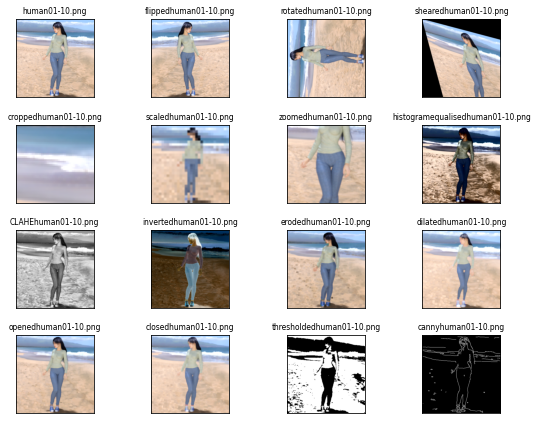

In [4]:
# Define The augmentation operations to be used
operations = {'flipped': 'horizontal', 'rotated': 90, 'sheared': {'x_axis': 5, 'y_axis': 15}, 'cropped': [50, 100, 50, 100], 'scaled': 0.1, 'zoomed': 2, 'histogramequalised':True, 'CLAHE':True, 'inverted':True, 'eroded':True, 'dilated':True, 'opened':True, 'closed':True,'thresholded':{'type':'adaptive','thresh_val':0}, 'canny':{'threshold_1':100,'threshold_2':200}}

# Apply The Augmentation
flow.applyAugmentation( operations )

## Train and test splits

The image dimensions to resize the image and split it is provided by the user as input. The arrays for `train_x`, `train_y`, `val_x`, `val_y` are created according to these parameters. All filtered and augmented images are moved to the processedData folder.

In [5]:
# To be given input by the user.
img_dimensions = (150, 150, 3)

# If working with greyscale image, change the number of channels from 3 to 1.
test_val_split = 0.25

# Select a random seed for splitting the data
random_state = 22

# Select one-hot or label encoding technique
encoding = 'one-hot'

# Obtain Train, Validation data splits
(train_x, train_y, val_x, val_y) = flow.getDataset( img_dimensions, test_val_split, random_state, encoding )

Percent: [----------] 0.0% Creating processedData Folder
Percent: [##########] 100% Created Datasets ...


## Assessing image quality

Image quality scores can be calculated for each image in the processedData folder using different metrics. The user can choose BRISQUE or Entropy measures to assess the image quality. The document is saved in the GeneratedReports folder as image_quality_report.docx.

In [6]:
# Create an image quality report using Entropy or BRISQUE for all images
image_quality = "entropy"
flow.calculateImageQuality( image_quality )

C:\Users\ACER\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Evaluating models

The library allows us to evaluate and plot ROC curves, confusion matrices and precision recall curves for any given model. We can first create a custom model to try the code on.

### Creating a custom model

In [7]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D

In [8]:
# Creating a datagenerator to process images from the directory containing 2 classes

datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1./255)

train_generator = datagen.flow_from_directory(
    './dataset_dir/data_dir', 
    subset = 'training',
    target_size = (300,300),
    batch_size = 16,
    class_mode = 'binary',
)
val_generator = datagen.flow_from_directory(
    './dataset_dir/data_dir', 
    subset = 'validation',
    target_size = (300,300),
    batch_size = 16,
    class_mode = 'binary'
)

Found 630 images belonging to 2 classes.
Found 210 images belonging to 2 classes.


In [9]:
# Creating the model architecture
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(300,300,3)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 296, 296, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 144, 144, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 331776)            0

In [10]:
# Compile and fit the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x=train_generator, validation_data=val_generator, epochs=5)

Epoch 1/5
40/40 [==============================] - 138s 3s/step - loss: 2.0705 - accuracy: 0.5904 - val_loss: 0.1283 - val_accuracy: 0.9952
Epoch 2/5
40/40 [==============================] - 133s 3s/step - loss: 0.2631 - accuracy: 0.9097 - val_loss: 0.0672 - val_accuracy: 1.0000
Epoch 3/5
40/40 [==============================] - 132s 3s/step - loss: 0.1516 - accuracy: 0.9390 - val_loss: 0.0479 - val_accuracy: 0.9810
Epoch 4/5
40/40 [==============================] - 132s 3s/step - loss: 0.1276 - accuracy: 0.9589 - val_loss: 0.0228 - val_accuracy: 0.9905
Epoch 5/5
40/40 [==============================] - 129s 3s/step - loss: 0.0744 - accuracy: 0.9611 - val_loss: 0.0420 - val_accuracy: 0.9810


### Evaluating the model using `Tf_Results`

`Tf_Results` is used for assessing custom Tensorflow models. It plots the ROC curve, Precision Recall curve, confusion matrix and saves those as images as well as a complete report in the GeneratedReports directory.

14/14 [==============================] - 9s 611ms/step


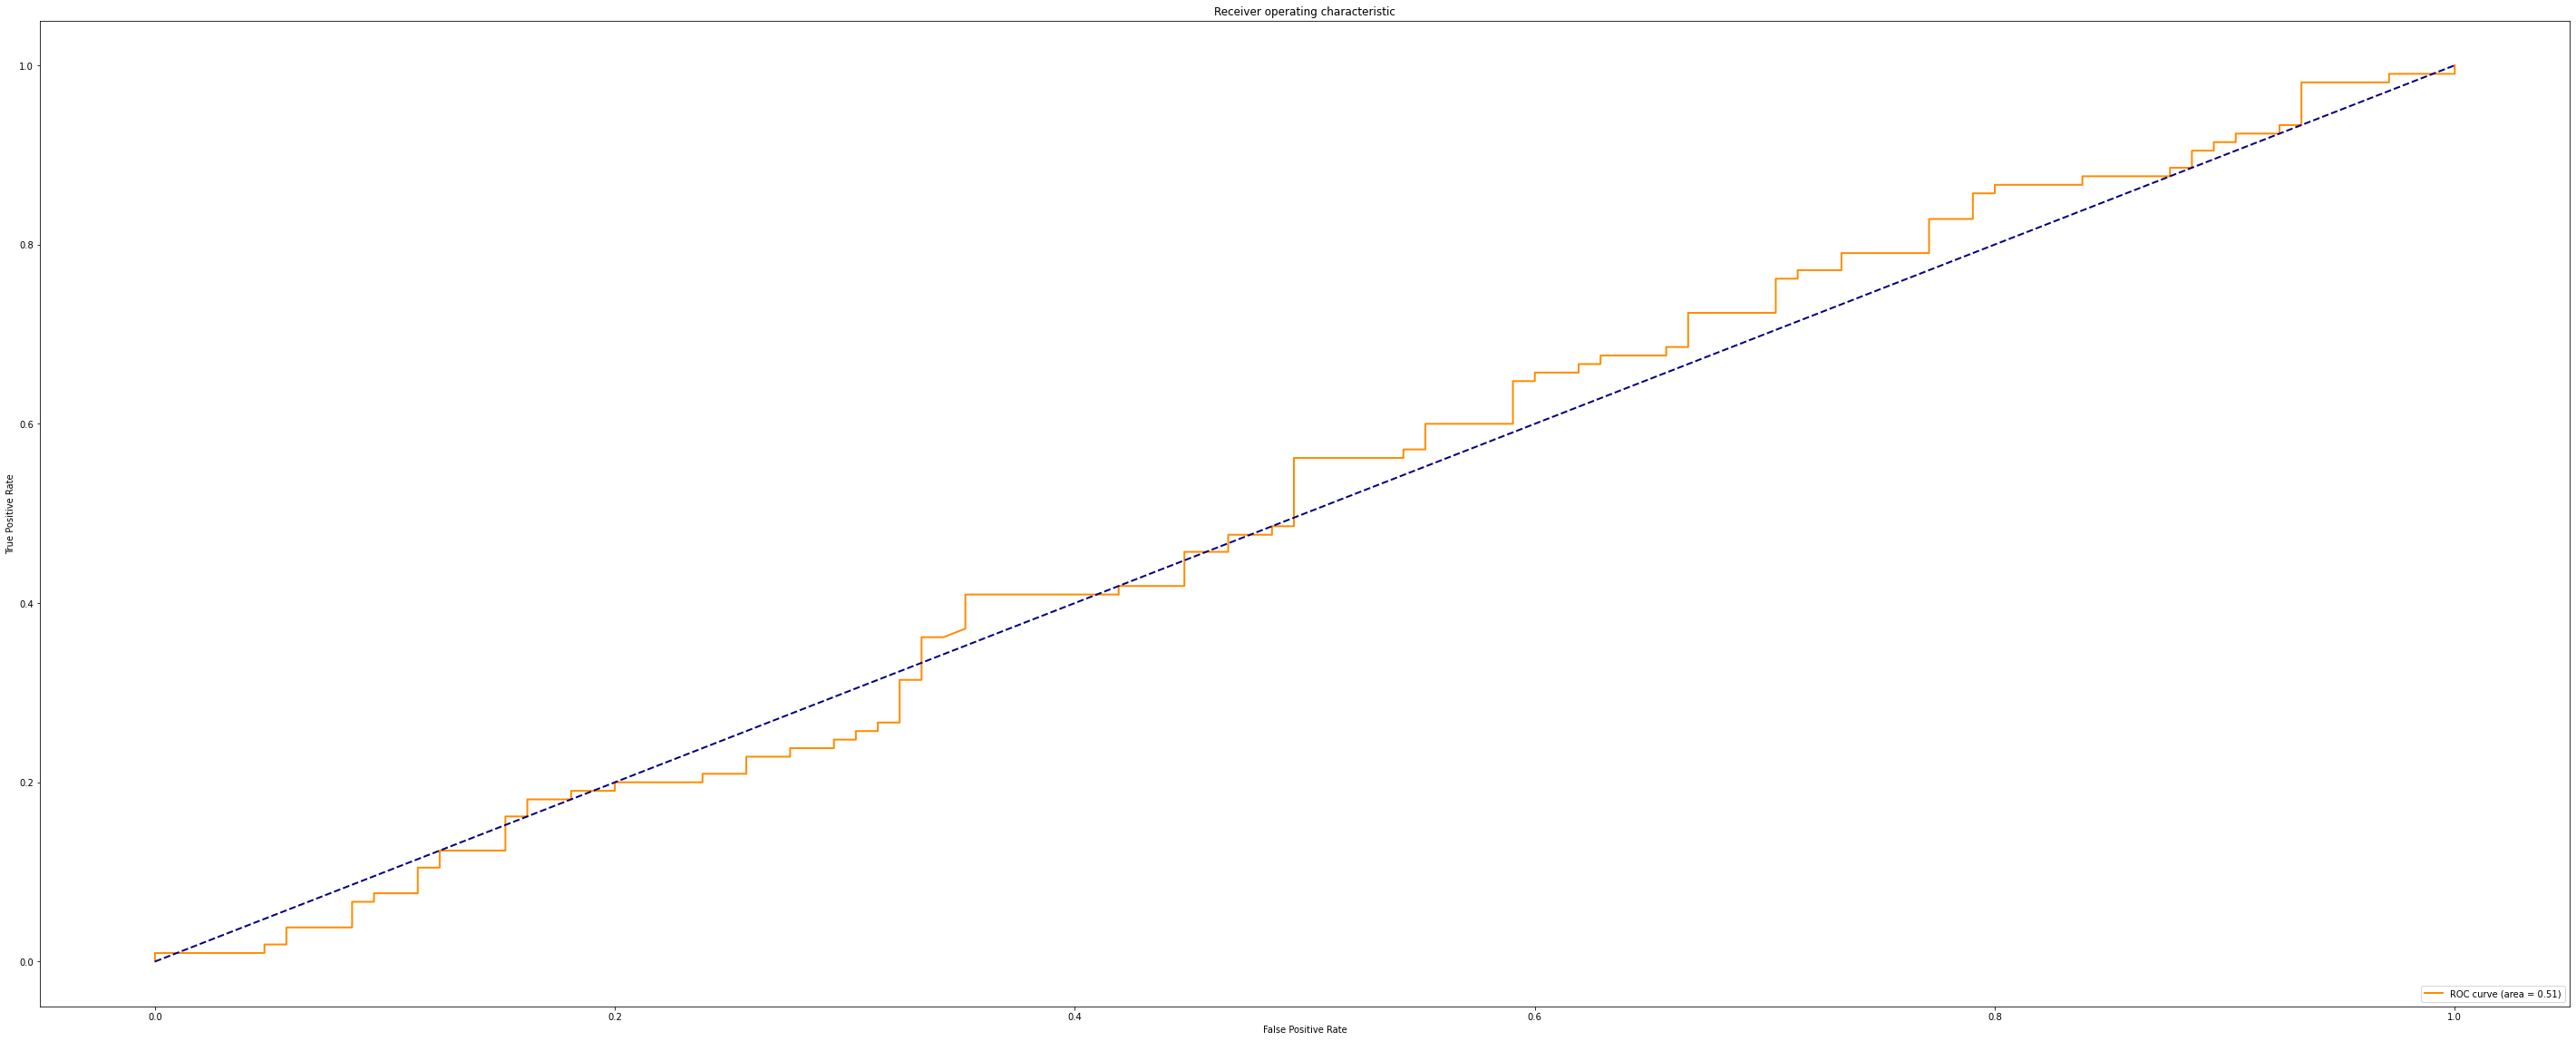

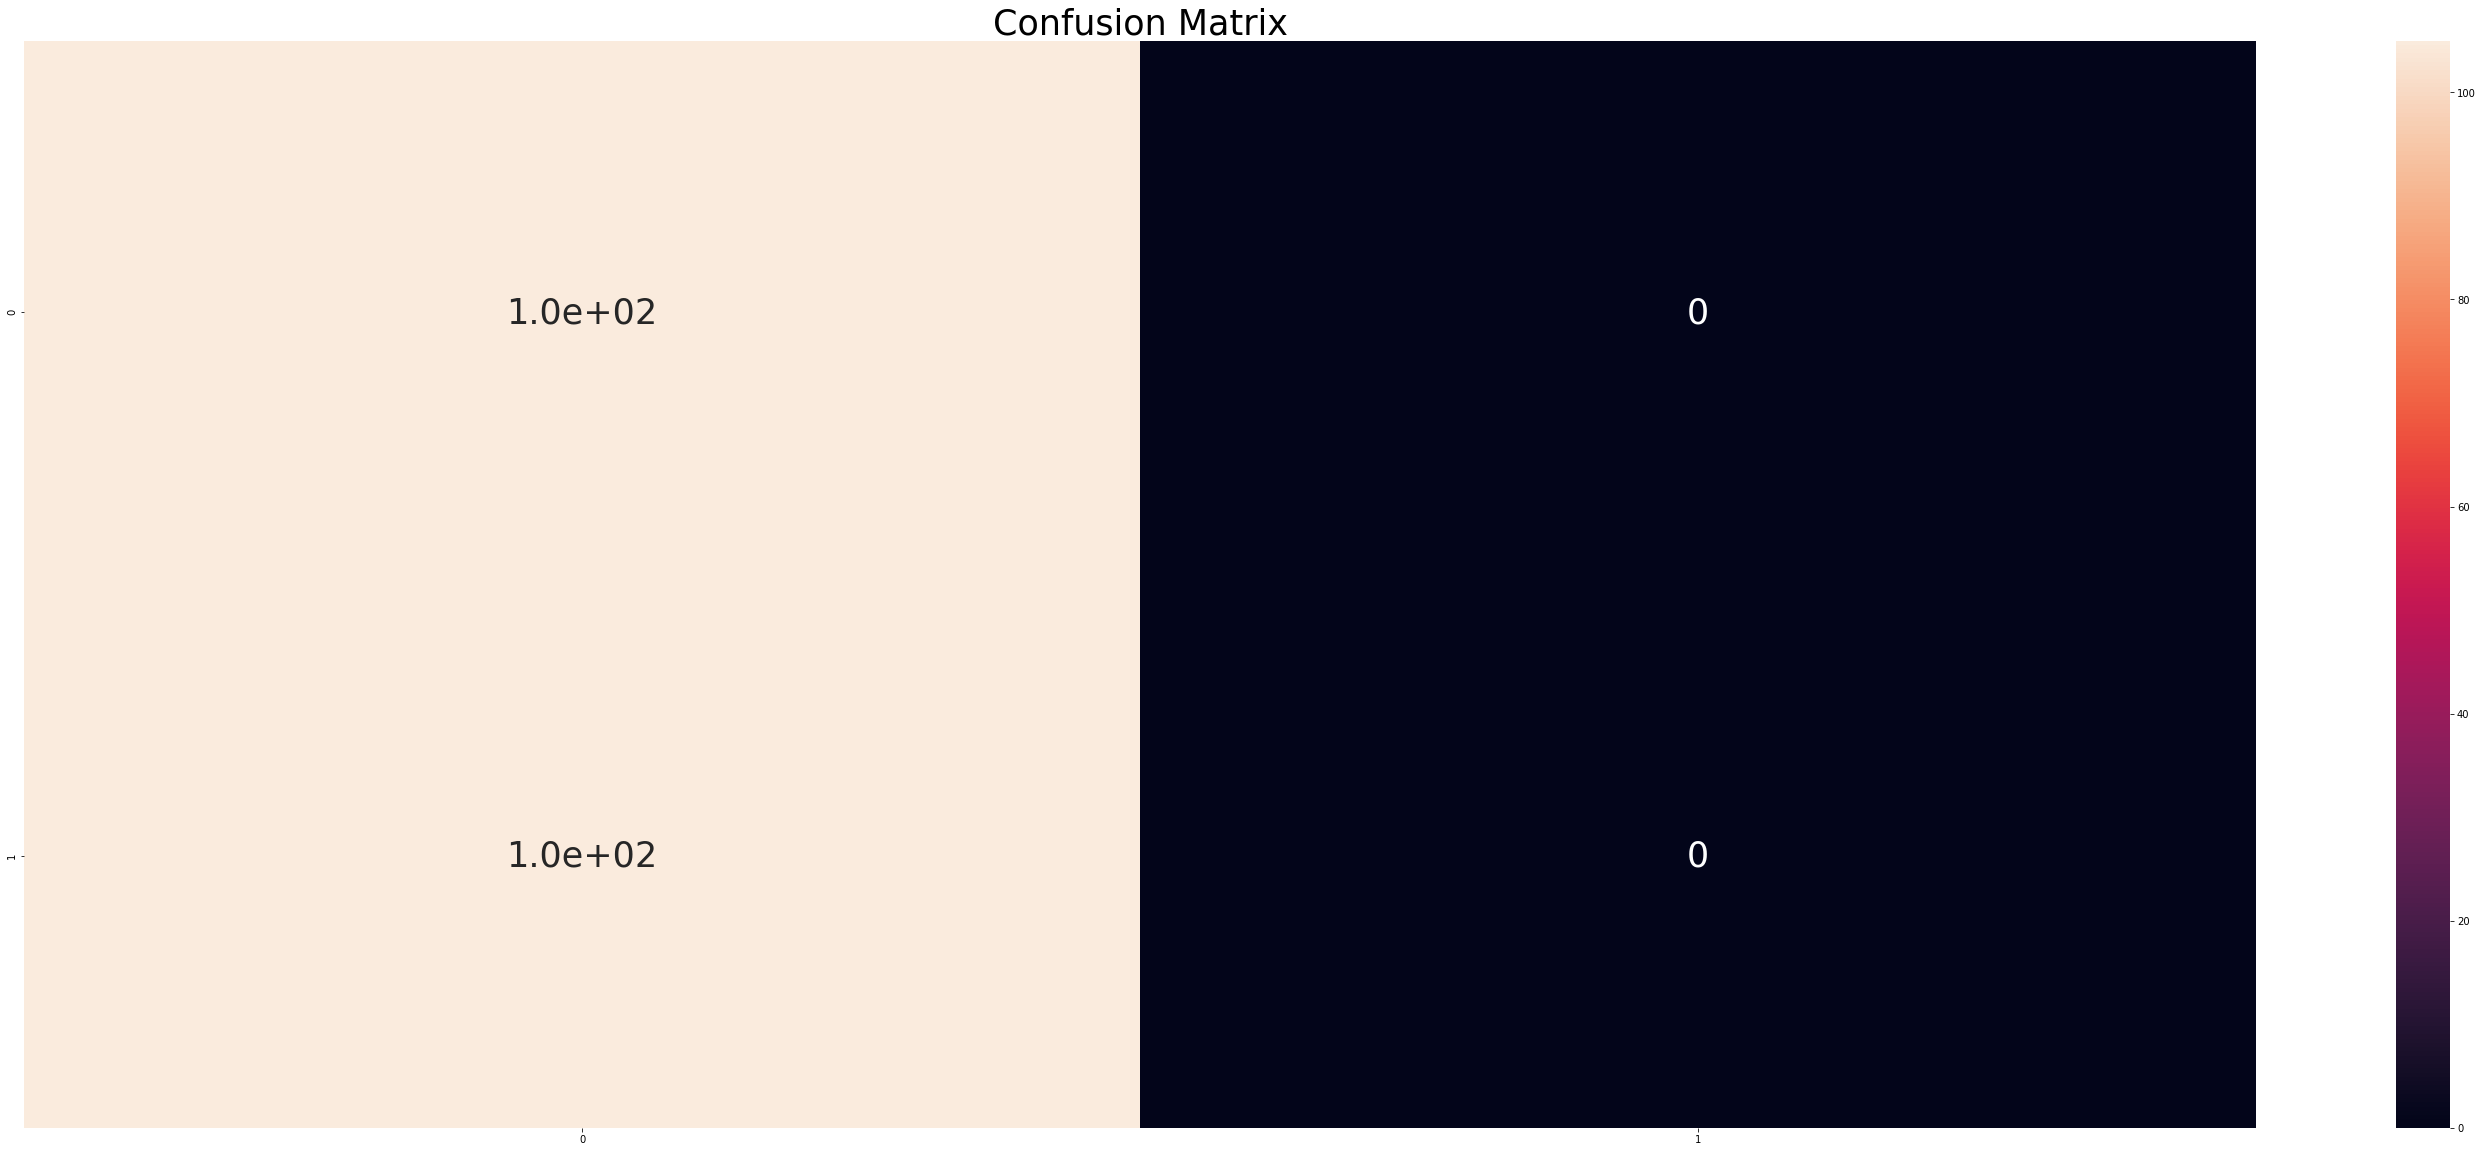

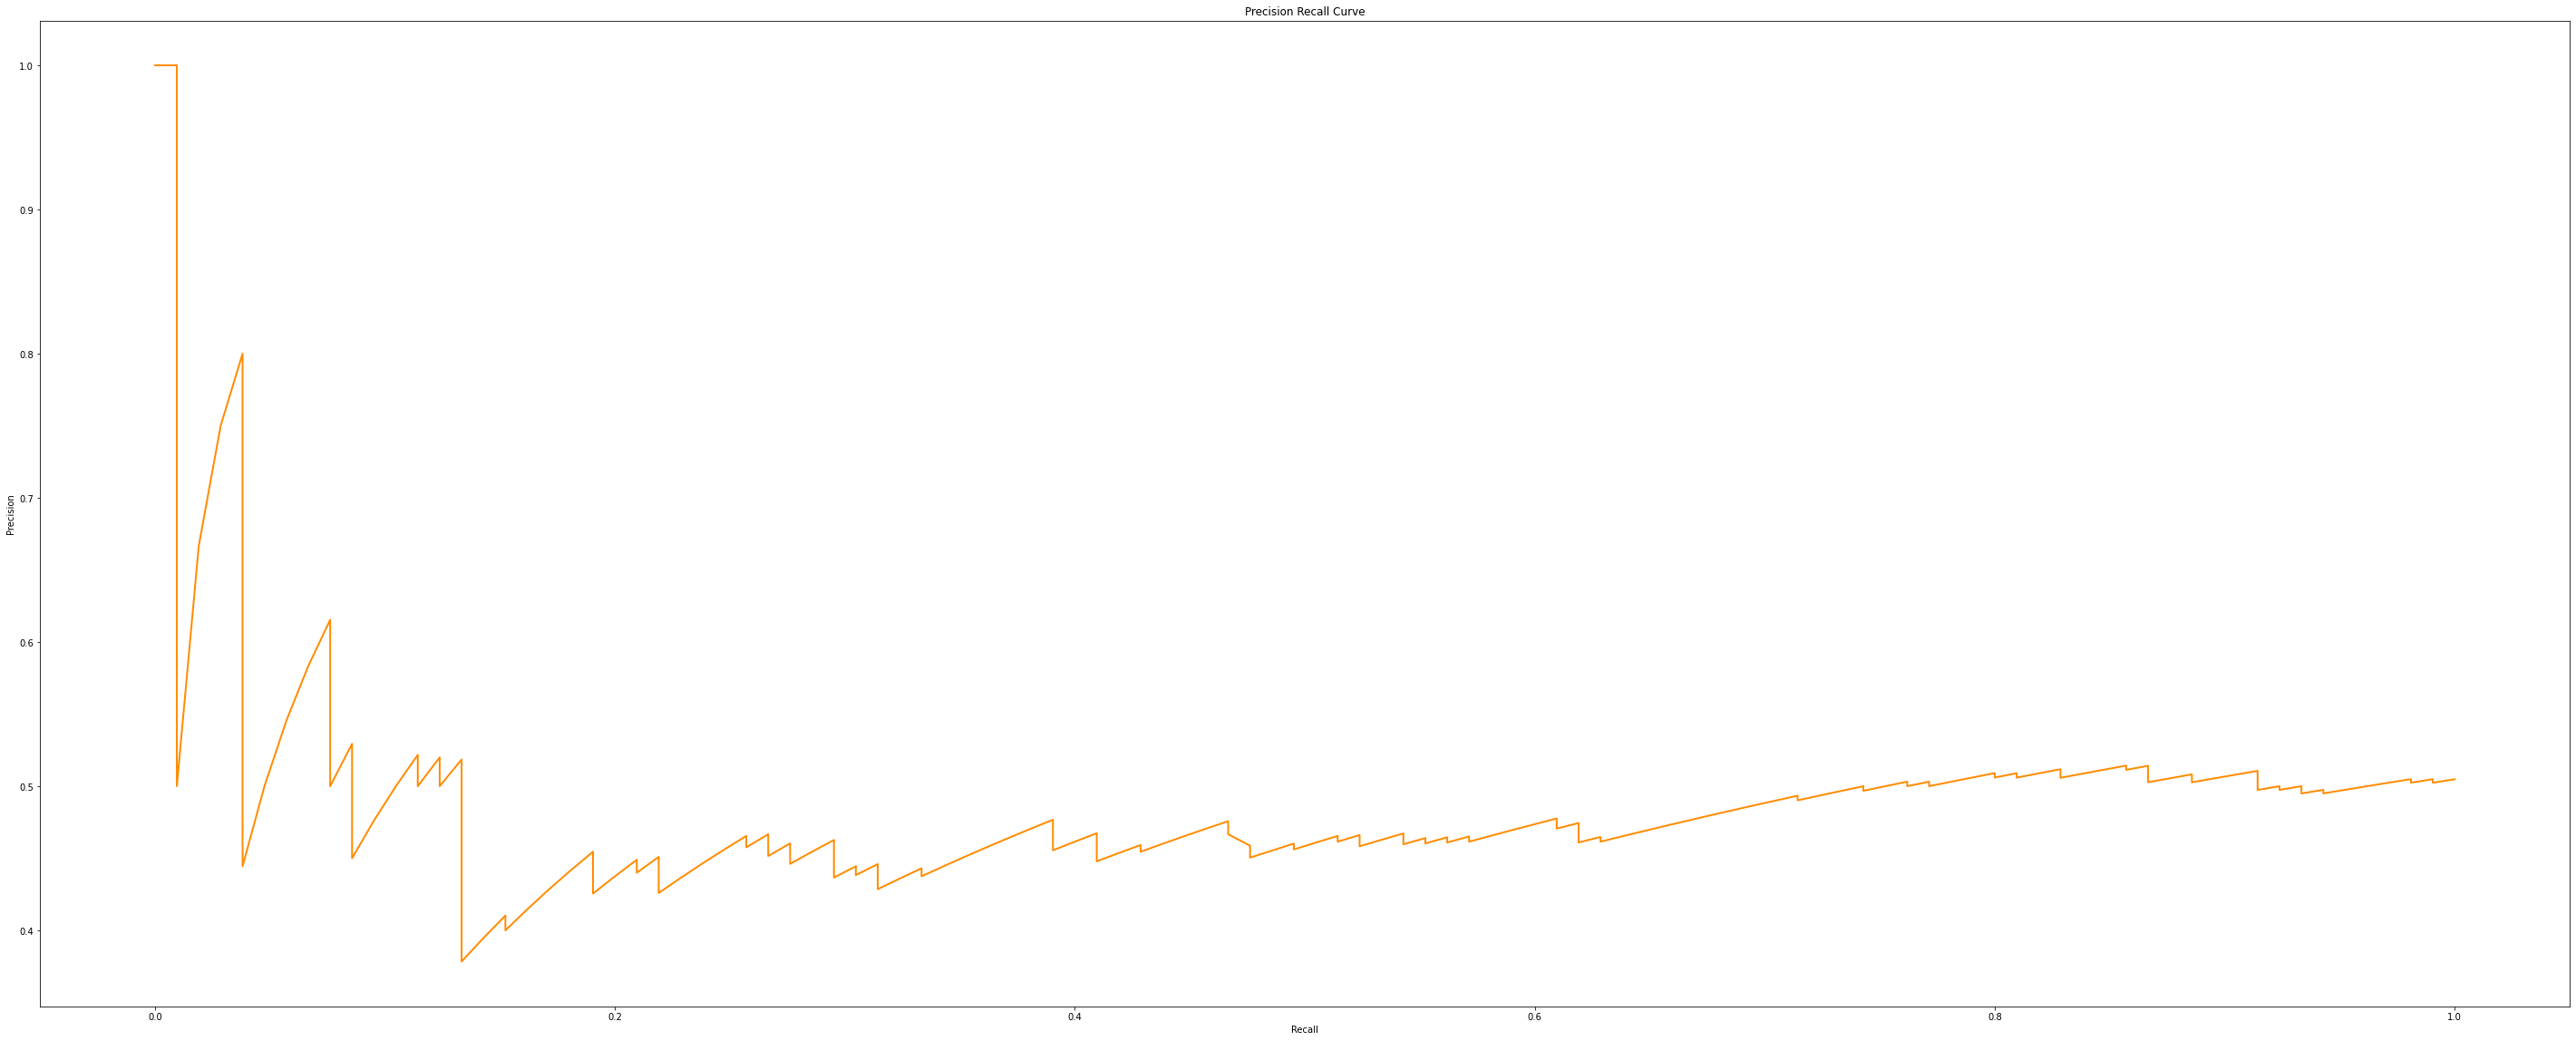

In [11]:
from flow2ml import Tf_Results

x = Tf_Results(model,val_generator)
x.tf_get_results_docx() 

## Model conversions

We can convert out custom model to tfjs or tflite format by specifying a dictionary of required conversions to pass to `deployTensorflowModels.` The converted models are stored in the DeployedModels folder.

In [12]:
# Define the conversions to be used
conversions = {'tfjs':True, 'tflite':True}

# convert tensorflow model to tfjs/tflite
flow.deployTensorflowModels( conversions, model )